[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/HyperCoast/blob/main/docs/examples/pace.ipynb)

# Visualizing PACE data using traditional python methods for plots and visualizations. However, data download uses HyperCoast.

This notebook demonstrates how to visualize [Plankton, Aerosol, Cloud, ocean Ecosystem (PACE)](https://pace.gsfc.nasa.gov) data interactively with HyperCoast.

In [1]:
# %pip install "hypercoast[extra]"

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import hypercoast
import netCDF4 as nc

import cartopy  #!pip install cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature
import mplcursors


---
# **_Option 1: Download PACE data using HyperCoast from NASA Earth Data_**
---
Not recommended for this Demo.

**Searching and downloading NASA Earth science data products**

Leafmap builds upon the [earthaccess](https://earthaccess.readthedocs.io) Python package to search and download NASA Earth science data products, making it easier visualize the footprints of the data products and download them interactively.

To download and access the data, you will need to create an Earthdata login. You can register for an account at [urs.earthdata.nasa.gov](https://urs.earthdata.nasa.gov).

In [3]:
hypercoast.nasa_earth_login()

You can search data by short name, doi, concept id, etc. You can find the list of NASA Earth science data products from the [NASA-Earth-Data](https://github.com/opengeos/NASA-Earth-Data) repo. The example below shows how to show the metadata of the 9,000+ NASA Earth science data products.

In [4]:
url = "https://github.com/opengeos/NASA-Earth-Data/raw/main/nasa_earth_data.tsv"
df = pd.read_csv(url, sep="\t")
df

,ShortName,EntryTitle,DOI,concept-id,provider-id,s3-links,bbox-crs,bbox,horizontal_res,start-time,end-time,Creator,Publisher,ReleaseDate,ReleasePlace,Version,Linkage
0,2009oct_Chesapeake,Chesapeake Bay measurements during October 2009,10.5067/SeaBASS/2009OCT_CHESAPEAKE/DATA001,C1633360083-OB_DAAC,OB_DAAC,NaN,CARTESIAN,"[-180.0, -90.0, 180.0, 90.0]",NaN,2009-10-12T00:00:02Z,NaN,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.5067/SeaBASS/2009OCT_CHESAP...
1,2dimpacts,Two-Dimensional Video Disdrometer (2DVD) IMPAC...,10.5067/IMPACTS/2DVD/DATA101,C1995564612-GHRC_DAAC,GHRC_DAAC,['ghrcw-protected/2dimpacts__1/'],CARTESIAN,"[-75.4912, 37.9194, -75.4462, 37.9543]",NaN,2020-01-15T01:37:06.000Z,2020-02-28T20:41:44.000Z,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.5067/IMPACTS/2DVD/DATA101
2,AAOT,Acqua Alta Oceanographic Tower (AAOT),10.5067/SeaBASS/AAOT/DATA001,C1633360084-OB_DAAC,OB_DAAC,NaN,CARTESIAN,"[-180.0, -90.0, 180.0, 90.0]",NaN,1999-08-03T00:00:02Z,NaN,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.5067/SeaBASS/AAOT/DATA001
3,AA_L2A,AMSR/ADEOS-II L2A Global Swath Spatially-Resam...,10.5067/ADEOS-II/AMSR/AA_L2A.001,C1241435536-NSIDC_ECS,NSIDC_ECS,NaN,CARTESIAN,"[-180.0, -90.0, 180.0, 90.0]",NaN,2003-01-18T00:00:00.000Z,2003-10-24T23:59:59.999Z,NaN,NASA National Snow and Ice Data Center Distrib...,NaN,NaN,1,https://doi.org/10.5067/ADEOS-II/AMSR/AA_L2A.001
4,ABI_G16-STAR-L2P-v2.70,GHRSST NOAA/STAR GOES-16 ABI L2P America Regio...,10.5067/GHG16-2PO27,C2036877465-POCLOUD,POCLOUD,['podaac-ops-cumulus-protected/ABI_G16-STAR-L2...,CARTESIAN,"[-135.0, -59.0, -15.0, 59.0]","[{'XDimension': 2000.0, 'YDimension': 2000.0, ...",2017-12-15T00:00:00.000Z,NaN,NOAA/NESDIS/STAR,PO.DAAC,2019-05-15T00:00:00.000Z,"Camp Springs, MD (USA)",2.70,https://doi.org/10.5067/GHG16-2PO27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9116,wilhend_687,"LBA Regional Vegetation and Soils, 1-Degree (W...",10.3334/ORNLDAAC/687,C2777328977-ORNL_CLOUD,ORNL_CLOUD,['s3://ornl-cumulus-prod-protected/lba/land_us...,CARTESIAN,"[-85.0, -25.0, -30.0, 10.0]",NaN,1900-01-01T00:00:00.000Z,1999-12-31T23:59:59.000Z,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.3334/ORNLDAAC/687
9117,willmott_673,"LBA Regional Climate Data, 0.5-Degree Grid, 19...",10.3334/ORNLDAAC/673,C2779732234-ORNL_CLOUD,ORNL_CLOUD,['s3://ornl-cumulus-prod-protected/lba/physica...,CARTESIAN,"[-85.0, -25.0, -30.0, 10.0]",NaN,1960-01-01T00:00:00.000Z,1990-12-31T23:59:59.000Z,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.3334/ORNLDAAC/673
9118,wisperimpacts,Water Isotope System for Precipitation and Ent...,10.5067/IMPACTS/WISPER/DATA101,C2175816611-GHRC_DAAC,GHRC_DAAC,['ghrcw-protected/wisperimpacts__1/'],CARTESIAN,"[-95.2426928, 33.2614038, -67.8781539, 48.2369...",NaN,2020-01-18T18:01:40.000Z,2023-02-28T15:35:37.000Z,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.5067/IMPACTS/WISPER/DATA101
9119,woody_biomass_657,"Woody Biomass for Eastern U.S. Forests, 1983-1996",10.3334/ORNLDAAC/657,C2808093948-ORNL_CLOUD,ORNL_CLOUD,['s3://ornl-cumulus-prod-protected/global_vege...,CARTESIAN,"[-100.0, 25.0, -60.0, 50.0]",NaN,1983-01-01T00:00:00.000Z,1996-12-31T23:59:59.000Z,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.3334/ORNLDAAC/657


To search data, specify the short name, bounding box, date range, etc. To return the footprints of the data, set `return_gdf=True`.

In [5]:
results, gdf = hypercoast.search_pace(
    bounding_box=(-83, 25, -81, 28),
    temporal=("2024-05-15", "2024-12-31"),
    count=10,  # use -1 to return all datasets
    return_gdf=True,
)

Granules found: 17


Visualize the footprints of the data on an interactive map.

In [6]:
gdf.explore()

Download the data to your local drive. Let's download the first 20 data products.

In [7]:
hypercoast.download_pace(results[:20], out_dir="data")

 Getting 10 granules, approx download size: 1.08 GB


QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

File PACE_OCI.20240515T182840.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240516T172513.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240516T185833.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240516T190333.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240518T182959.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240518T183459.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240517T180006.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240519T173132.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240519T190951.L2.OC_AOP.V1_0_0.NRT.nc already downloaded
File PACE_OCI.20240520T180124.L2.OC_AOP.V1_0_0.NRT.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

# Choose the PACE file that you want to view with HyperCoast from the list below:

In [8]:
def list_nc_files_with_sizes_and_dates(directory):
    """List all .nc files in the given directory along with their sizes and dates."""
    files_with_sizes_and_dates = []
    for file in os.listdir(directory):
        if file.endswith('.nc'):
            # Extract date from file name
            match = re.search(r'\d{8}', file)
            if match:
                date_str = match.group(0)
                # Parse the date string into a tuple (year, month, day)
                date_tuple = (int(date_str[:4]), int(date_str[4:6]), int(date_str[6:8]))
                file_path = os.path.join(directory, file)
                file_size = os.path.getsize(file_path)
                files_with_sizes_and_dates.append((file, file_size, date_tuple))
    return files_with_sizes_and_dates

def display_menu(files_with_sizes_and_dates):
    """Display a menu of files for the user to choose from, including their sizes in MB and dates."""
    print("Please choose a file from the list below:")
    for idx, (file, size, date) in enumerate(files_with_sizes_and_dates):
        size_mb = size / 1_000_000  # Convert size to MB using decimal units
        #print(f"File #{idx + 1}: {file} (Size: {size_mb:,.1f} MB, Date: {date[0]}-{date[1]:02}-{date[2]:02})")
        print(f"File #{idx + 1}: {file} ({idx+1}, Size: {size_mb:,.1f} MB, Date: {date[0]}-{date[1]:02}-{date[2]:02})")

def get_user_choice(files_with_sizes_and_dates):
    """Get the user's choice and return the selected file path."""
    while True:
        try:
            choice = int(input("Enter the number of the file you want to choose: "))
            if 1 <= choice <= len(files_with_sizes_and_dates):
                return files_with_sizes_and_dates[choice - 1][0]  # Return the chosen file name
            else:
                print(f"Invalid choice. Please enter a number between 1 and {len(files_with_sizes_and_dates)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

# Specify the directory
directory = "data"

# List all .nc files in the directory with their sizes and dates
nc_files_with_sizes_and_dates = list_nc_files_with_sizes_and_dates(directory)

# Sort files by date (oldest to newest)
nc_files_with_sizes_and_dates.sort(key=lambda x: x[2])

# Display the menu
display_menu(nc_files_with_sizes_and_dates)

# Get the user's choice
chosen_file = get_user_choice(nc_files_with_sizes_and_dates)

# Construct the full file path
filepath = os.path.join(directory, chosen_file)

# Print the chosen file path (or you can proceed with reading the file)
print(f"Chosen file path: {filepath}")



Please choose a file from the list below:
File #1: PACE_OCI.20240515T182840.L2.OC_AOP.V1_0_0.NRT.nc (1, Size: 117.1 MB, Date: 2024-05-15)
File #2: PACE_OCI.20240516T172513.L2.OC_AOP.V1_0_0.NRT.nc (2, Size: 171.3 MB, Date: 2024-05-16)
File #3: PACE_OCI.20240516T185833.L2.OC_AOP.V1_0_0.NRT.nc (3, Size: 152.0 MB, Date: 2024-05-16)
File #4: PACE_OCI.20240516T190333.L2.OC_AOP.V1_0_0.NRT.nc (4, Size: 18.6 MB, Date: 2024-05-16)
File #5: PACE_OCI.20240517T180006.L2.OC_AOP.V1_0_0.NRT.nc (5, Size: 114.3 MB, Date: 2024-05-17)
File #6: PACE_OCI.20240518T182959.L2.OC_AOP.V1_0_0.NRT.nc (6, Size: 243.4 MB, Date: 2024-05-18)
File #7: PACE_OCI.20240518T183459.L2.OC_AOP.V1_0_0.NRT.nc (7, Size: 31.6 MB, Date: 2024-05-18)
File #8: PACE_OCI.20240519T173132.L2.OC_AOP.V1_0_0.NRT.nc (8, Size: 119.3 MB, Date: 2024-05-19)
File #9: PACE_OCI.20240519T190951.L2.OC_AOP.V1_0_0.NRT.nc (9, Size: 39.4 MB, Date: 2024-05-19)
File #10: PACE_OCI.20240520T180124.L2.OC_AOP.V1_0_0.NRT.nc (10, Size: 156.0 MB, Date: 2024-05-20)

Enter the number of the file you want to choose:  6


Chosen file path: data/PACE_OCI.20240518T182959.L2.OC_AOP.V1_0_0.NRT.nc


---
# **_Option 2: Download PACE data from HyperCoast GitHub Site_**
---

**For this Example we recommend using the HyperCoast .nc file that they provide and not from a choice above:**

In [9]:
url = "https://github.com/opengeos/datasets/releases/download/netcdf/PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc"


filepath = "PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc"
hypercoast.download_file(url)



#filepath = "/Users/craig/Downloads/HyperCoast_Projects_Craig/1_HyperCoast_from_Dr_Wu_CP/docs/examples/PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc" # main

PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc already exists. Skip downloading. Set overwrite=True to overwrite.


'/Users/craig/Downloads/HyperCoast_Projects_Craig/2_Craigs_PACE_Reflectance_works_great_HyperCoast/PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc'

# What is contained in our selected .nc data file:
---

The *.nc files you're referring to are NetCDF (Network Common Data Form) files. NetCDF is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. Here's a bit more detail on what these files are and how they are typically used:

### What is a NetCDF File?

1. **Format**: NetCDF files are designed to store large arrays of scientific data. They can handle complex data structures, including multidimensional arrays, and can contain metadata that describes the data contained within the file.

2. **Usage**: These files are commonly used in the fields of meteorology, oceanography, and climate science to store observational data, model outputs, and other types of scientific data. NASA's PACE (Plankton, Aerosol, Cloud, ocean Ecosystem) mission, which aims to provide advanced measurements of ocean color, aerosol, and cloud properties, uses NetCDF files to distribute its data.

3. **Data Access and Manipulation**: NetCDF files can be accessed and manipulated using a variety of software tools and programming languages, including:
   - **Python**: Libraries such as `netCDF4`, `xarray`, and `h5netcdf` are commonly used to read and manipulate NetCDF files.
   - **MATLAB**: Provides built-in support for reading and writing NetCDF files.
   - **R**: Packages like `ncdf4` and `RNetCDF` are used for working with NetCDF data.
   - **Command-line Tools**: The NetCDF library provides command-line utilities like `ncdump` and `ncgen` for examining and creating NetCDF files.

### Key Features of NetCDF Files

1. **Self-describing**: NetCDF files contain metadata that describes the contents of the file, such as the dimensions, variables, and attributes. This self-describing nature makes it easier to understand the data without needing external documentation.

2. **Portable**: NetCDF is designed to be machine-independent, meaning the same file can be read on different types of computer systems without modification.

3. **Efficient Access**: The format allows for efficient access to subsets of large datasets, which is crucial for working with large volumes of scientific data.

### Working with NetCDF Files

A practical example of how you might work with NetCDF files using Python, here is a simple code snippet using the `netCDF4` library:

```python
import netCDF4 as nc

# Open a NetCDF file
dataset = nc.Dataset('path_to_your_file.nc')

# Explore the dimensions
print(dataset.dimensions)

# Explore the variables
print(dataset.variables)

# Access a specific variable
temperature = dataset.variables['temperature'][:]

# Close the dataset
dataset.close()
```

In this snippet, replace `'path_to_your_file.nc'` with the actual path to your NetCDF file. You can explore the structure of the dataset, including its dimensions and variables, and extract the data for analysis.

NetCDF files are a powerful tool for managing complex scientific data, and their wide adoption across various scientific disciplines attests to their versatility and robustness. 

We found the following code used to exploer our NetCDF data:

    Author: Guoqing Wang (guoqing.wang@nasa.gov), OB.DAAC Scientist, NASA GSFC; SSAI



## **1. Loading the Level-2 Dataset** <br>
---

    Author: Guoqing Wang (guoqing.wang@nasa.gov), OB.DAAC Scientist, NASA GSFC; SSAI


NASA ocean color data are stored in NetCDF files. They can be read with a few different Python modules. The most popular are netCDF4 and gdal. For this script we’ll focus on netCDF4.<br>
Loading a dataset is simple, just pass a NetCDF file path to netCDF4.Dataset().

In [10]:
# open file and print the metadata
dataset = nc.Dataset(filepath, 'r')

A NetCDF file consists of three fundamental components: metadata, dimensions, and variables. Variables encompass both metadata and data. The netCDF4 library enables us to retrieve the metadata and data linked to a NetCDF file.

## **2. Retrieve Metadata**
---

<br>When we print the dataset f, it provides details about the variables present in the file as well as the groups of variables.

In [11]:
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: OCI Level-2 Data
    product_name: PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc
    processing_version: V1.0.0
    history: l2gen par=/data5/sdpsoper/vdc/vpu24/workbuf/PACE_OCI.20240423T184658.L1B.nc.param metafile=PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc.meta
    instrument: OCI
    platform: PACE
    Conventions: CF-1.6 ACDD-1.3
    license: https://science.nasa.gov/earth-science/earth-science-data/data-information-policy/
    naming_authority: gov.nasa.gsfc.sci.oceandata
    id: V1.0.0/L2/PACE_OCI.20240423T184658.L2.OC_AOP.V1_0_0.NRT.nc
    date_created: 2024-04-23T20:49:05.000Z
    standard_name_vocabulary: CF Standard Name Table v36
    institution: NASA Goddard Space Flight Center, Ocean Ecology Laboratory, Ocean Biology Processing Group
    creator_name: NASA/GSFC/OBPG
    creator_email: data@oceancolor.gsfc.nasa.gov
    creator_url: https://oceandata.sci.gsfc.nasa.gov
  

Above you can see information for the file format, data source, data version, citation, dimensions, and variables. In L2 ocean color data, the variables are put in different groups, the ones that we are interested in, such as Rrs, Chla, etc. are in "geophysical_data", and lat, lon are in "navigation_data"

In [12]:
# print grouped variables
print(dataset.groups.keys())

dict_keys(['sensor_band_parameters', 'scan_line_attributes', 'geophysical_data', 'navigation_data', 'processing_control'])


## **3. Dimensions** 
---
<br>Accessing dimensions is akin to accessing file metadata. Each dimension is stored as a dimension class that holds relevant information. To retrieve metadata for all dimensions, one can loop through all the available dimensions, as demonstrated below.

In [13]:
for dim in dataset.dimensions.values():
    print(dim)
    

<class 'netCDF4._netCDF4.Dimension'>: name = 'number_of_lines', size = 1710
<class 'netCDF4._netCDF4.Dimension'>: name = 'pixels_per_line', size = 1272
<class 'netCDF4._netCDF4.Dimension'>: name = 'bands_per_pixel', size = 286
<class 'netCDF4._netCDF4.Dimension'>: name = 'number_of_reflectance_location_values', size = 10
<class 'netCDF4._netCDF4.Dimension'>: name = 'number_of_cloud_phases', size = 2
<class 'netCDF4._netCDF4.Dimension'>: name = 'pixel_control_points', size = 1272
<class 'netCDF4._netCDF4.Dimension'>: name = 'number_of_bands', size = 286
<class 'netCDF4._netCDF4.Dimension'>: name = 'number_of_reflective_bands', size = 286
<class 'netCDF4._netCDF4.Dimension'>: name = 'wavelength_3d', size = 184


## **4. Variable Metadata** <br>
---
Access variable metadata in the groups of "geophysical_data" and "navigation_data". 

In [14]:
#print(f.groups['geophysical_data'].variables)
# if you just want to see the variable names, use the following code
print(dataset.groups['geophysical_data'].variables.keys())

dict_keys(['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw', 'l2_flags'])


## **5. Access Data Values**
---
<br>The actual precipitation data values are accessed by array indexing, and a numpy array is returned. All variable data is returned as follows:

In [15]:
# metadata of variable: chlor_a
print(dataset.groups['geophysical_data'].variables['Rrs'])

<class 'netCDF4._netCDF4.Variable'>
int16 Rrs(number_of_lines, pixels_per_line, wavelength_3d)
    long_name: Remote sensing reflectance
    scale_factor: 2e-06
    add_offset: 0.05
    units: sr^-1
    standard_name: surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air
    _FillValue: -32767
    valid_min: -30000
    valid_max: 25000
path = /geophysical_data
unlimited dimensions: 
current shape = (1710, 1272, 184)
filling on


In [16]:
rrs = dataset.groups['geophysical_data'].variables['Rrs']
rrs

<class 'netCDF4._netCDF4.Variable'>
int16 Rrs(number_of_lines, pixels_per_line, wavelength_3d)
    long_name: Remote sensing reflectance
    scale_factor: 2e-06
    add_offset: 0.05
    units: sr^-1
    standard_name: surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air
    _FillValue: -32767
    valid_min: -30000
    valid_max: 25000
path = /geophysical_data
unlimited dimensions: 
current shape = (1710, 1272, 184)
filling on

In [17]:
#reflectance_data

In [18]:
# read information of lat, lon
print(dataset.groups['navigation_data'].variables.keys())
lat = dataset.groups['navigation_data'].variables['latitude'][:]
lon = dataset.groups['navigation_data'].variables['longitude'][:]
print(lat.shape)
print(lon.shape)
print(lat)
#print(rrs.shape)
##########rrs = np.log10(rrs)


dict_keys(['longitude', 'latitude', 'cntl_pt_cols', 'cntl_pt_rows', 'tilt'])
(1710, 1272)
(1710, 1272)
[[11.074572 11.096266 11.117669 ... 16.09963  16.103954 16.108276]
 [11.084808 11.106506 11.127914 ... 16.110056 16.114374 16.118698]
 [11.095317 11.117015 11.138422 ... 16.120537 16.124857 16.129173]
 ...
 [33.735363 33.755054 33.771652 ... 39.27378  39.283314 39.293877]
 [33.74528  33.764465 33.7817   ... 39.284252 39.29461  39.304325]
 [33.754604 33.773712 33.791676 ... 39.29418  39.305233 39.31491 ]]


## **6. Visualization and mapping**
---

<br>Here, we use cartopy for basemap creation and matplotlib to plot data onto the created map.
The combination of Matplotlib and Cartopy provides a powerful toolkit for creating geospatial visualizations.

this is a test below by lat and lon for different samples: 

## **Wavelengths vs. Reflectance Plots Similar to STELLA Data:**
---

In [19]:

# Extract the necessary variables from the identified group and variable names
reflectance_data = dataset['geophysical_data']['Rrs'][:]  # Adjust based on identified variable names
latitudes = dataset['navigation_data']['latitude'][:]
longitudes = dataset['navigation_data']['longitude'][:]
wavelengths = dataset['sensor_band_parameters']['wavelength'][:184]  # Adjust based on identified variable names and ensure it matches the 184 wavelength channels

# Print shapes to understand their structure
print(f"Reflectance data shape: {reflectance_data.shape}")
print(f"Latitudes shape: {latitudes.shape}")
print(f"Longitudes shape: {longitudes.shape}")
print()
print()
print(f"Wavelengths: {wavelengths}")


# Function to find the closest grid point to the target latitude and longitude
def find_closest_grid_point(latitudes, longitudes, target_latitude, target_longitude):
    # Calculate the distance between the target point and each grid point
    distances = np.sqrt((latitudes - target_latitude)**2 + (longitudes - target_longitude)**2)
    
    # Find the index of the minimum distance
    min_distance_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    return min_distance_idx


def plot_wavelength(target_latitude, target_longitude):
    # Find the closest grid point to the target latitude and longitude
    lat_idx, lon_idx = find_closest_grid_point(latitudes, longitudes, target_latitude, target_longitude)

    # Extract reflectance data for the grid point across all wavelengths
    reflectance_spectrum = reflectance_data[lat_idx, lon_idx, :]

    # Ensure the dimensions match
    print(f"Wavelengths shape: {wavelengths.shape}")
    print(f"Reflectance spectrum shape: {reflectance_spectrum.shape}")

    # Plot reflectance vs. wavelength
    plt.figure(figsize=(12, 6))
    #plt.plot(wavelengths, reflectance_spectrum, marker='o',color='red')
    plt.plot(wavelengths, reflectance_spectrum,color='red',linewidth=3)
    plt.xlim(300,1000)
    plt.ylim(0,0.02)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title(f'PACE Reflectance Spectrum at Lat: {latitudes[lat_idx, lon_idx]}, Lon: {longitudes[lat_idx, lon_idx]}')


    # Edge colors picked from image below and sent to Mike 
    plt.axvspan(300, 400, alpha=0.5, color='purple',label='Near UV from 300-400m')
    plt.axvspan(400, 450, alpha=0.5, color='violet',label='Violet 400-450m')
    plt.axvspan(450, 495, alpha=0.2, color='blue',label='Blue from 450-495nm')
    plt.axvspan(495, 550, alpha=0.2, color='green',label='Green from 495-550nm')
    plt.axvspan(550, 590, alpha=0.2, color='yellow',label='Yellow from 550-590nm')
    plt.axvspan(590, 630, alpha=0.2, color='orange',label='Orange from 590-630nm')
    plt.axvspan(630, 700, alpha=0.2, color='red',label='Red from 630-700nm')
    plt.axvspan(700, 1000, alpha=1, color='lavender',label='Near IR from 700-1,000nm')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


    plt.grid(True)
    plt.show()


Reflectance data shape: (1710, 1272, 184)
Latitudes shape: (1710, 1272)
Longitudes shape: (1710, 1272)


Wavelengths: [315 316 318 320 322 325 327 329 331 334 337 339 341 344 346 348 351 353
 356 358 361 363 366 368 371 373 375 378 380 383 385 388 390 393 395 398
 400 403 405 408 410 413 415 418 420 422 425 427 430 432 435 437 440 442
 445 447 450 452 455 457 460 462 465 467 470 472 475 477 480 482 485 487
 490 492 495 497 500 502 505 507 510 512 515 517 520 522 525 527 530 532
 535 537 540 542 545 547 550 553 555 558 560 563 565 568 570 573 575 578
 580 583 586 588 591 593 596 598 601 603 605 608 610 613 615 618 620 623
 625 627 630 632 635 637 640 641 642 643 645 646 647 648 650 651 652 653
 655 656 657 658 660 661 662 663 665 666 667 668 670 671 672 673 675 676
 677 678 679 681 682 683 684 686 687 688 689 691 692 693 694 696 697 698
 699 701 702 703]


## **Wavelength vs. Reflectiance for select pixel locations:**

This works well and plots fast, but finding the lat/lon with data is difficult. Get points from HyperCoast.

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


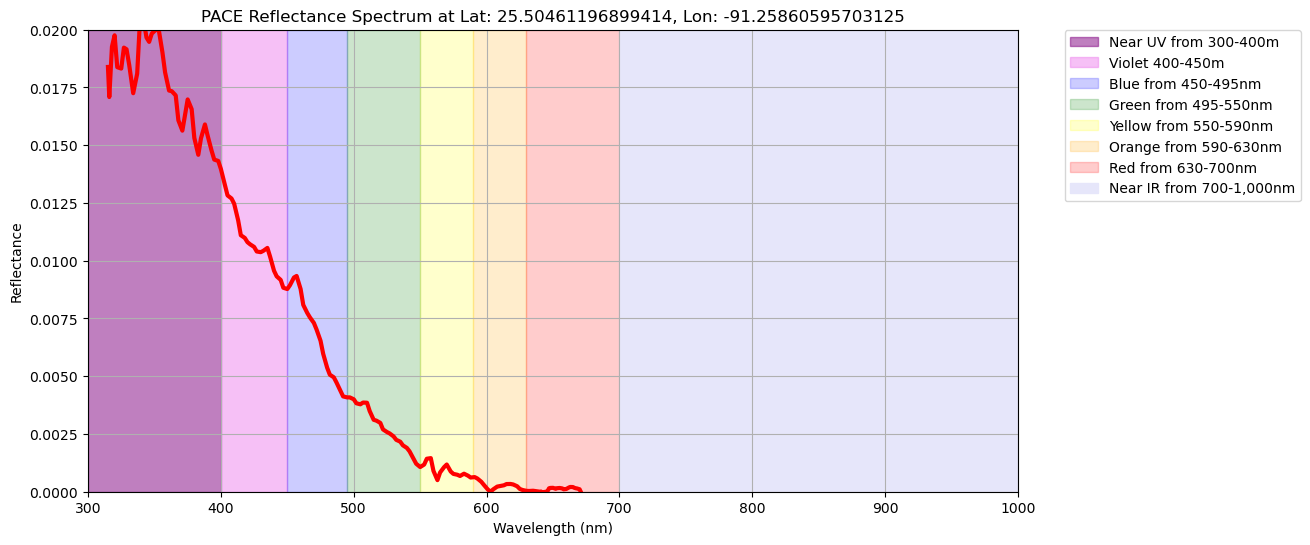

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


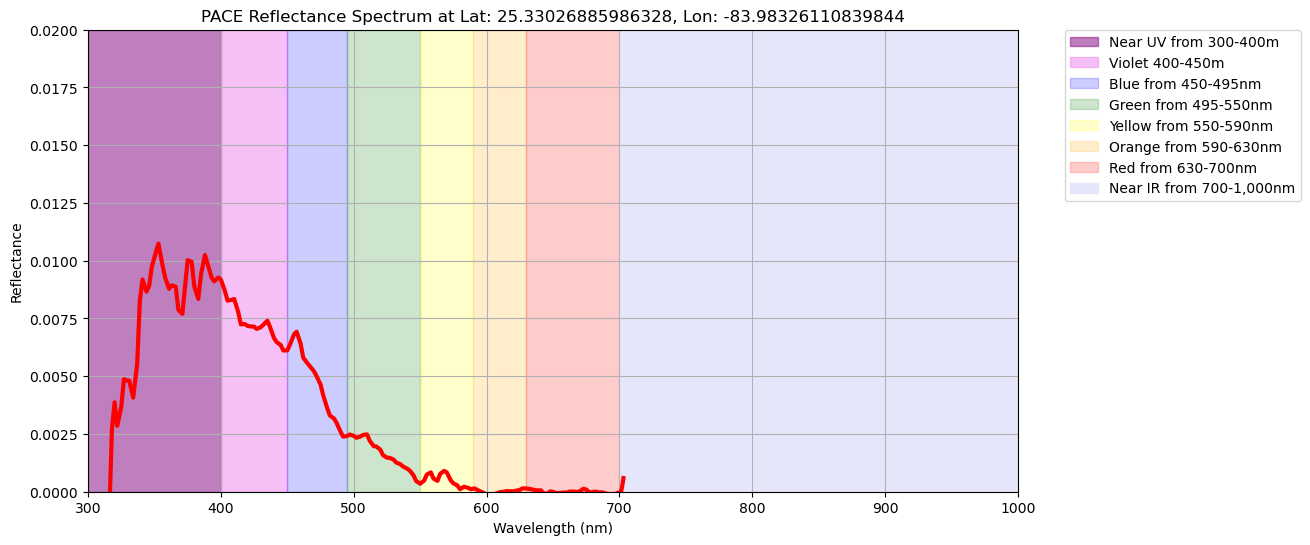

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


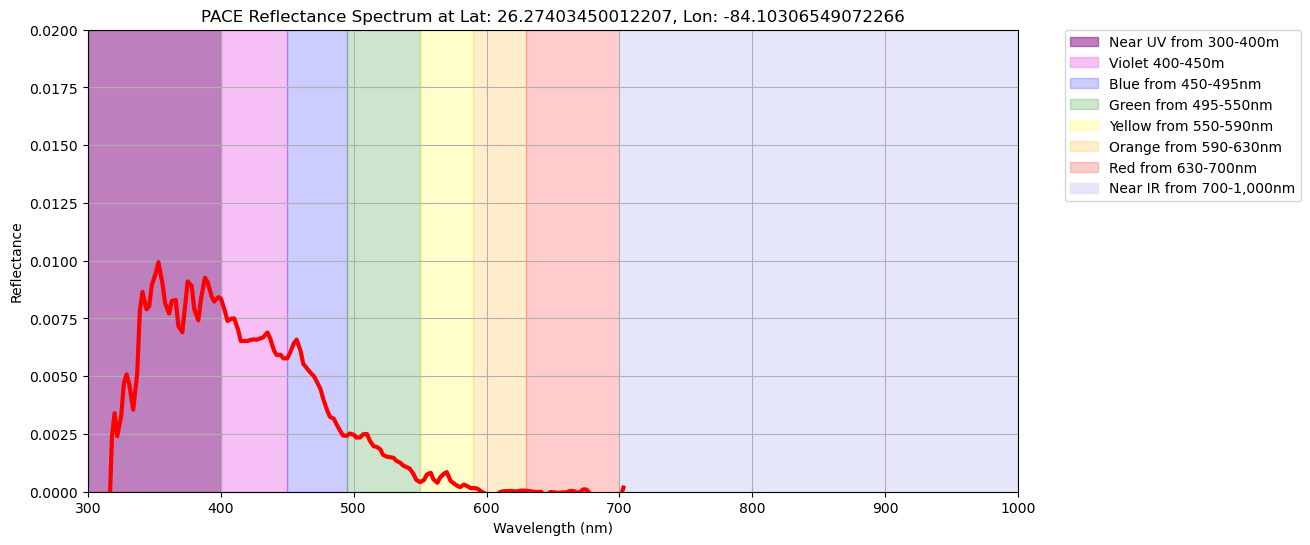

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


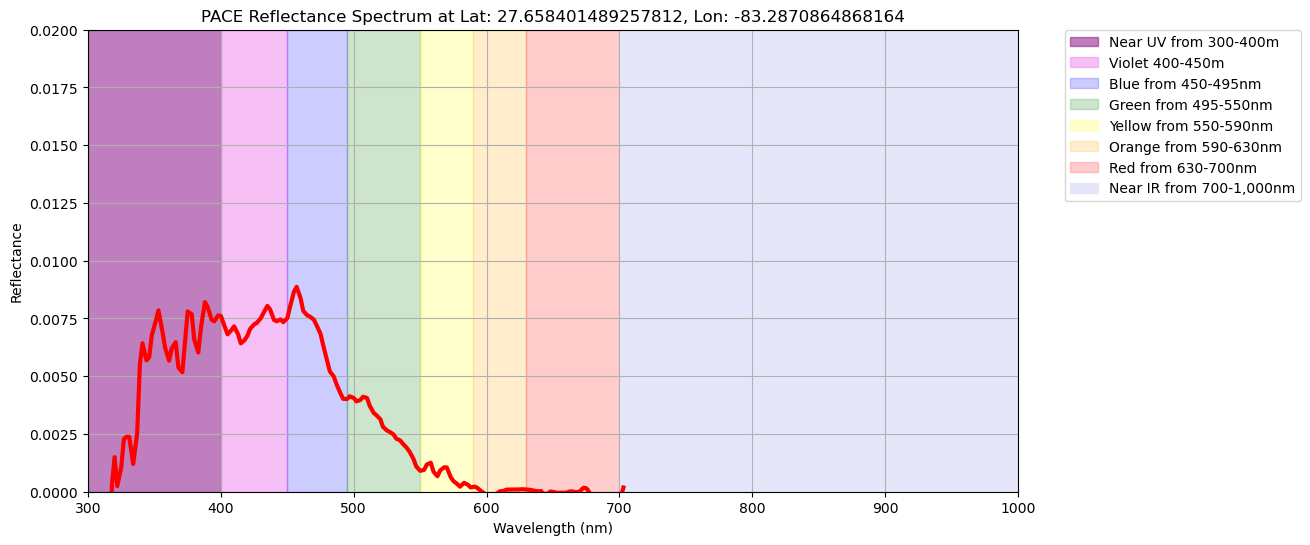

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


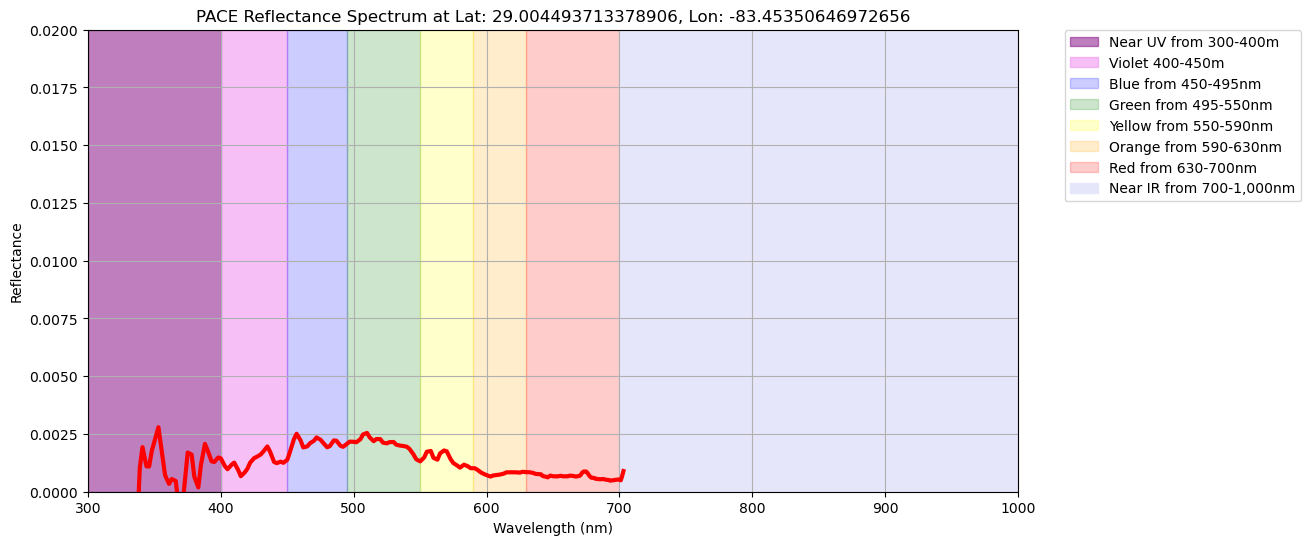

Wavelengths shape: (184,)
Reflectance spectrum shape: (184,)


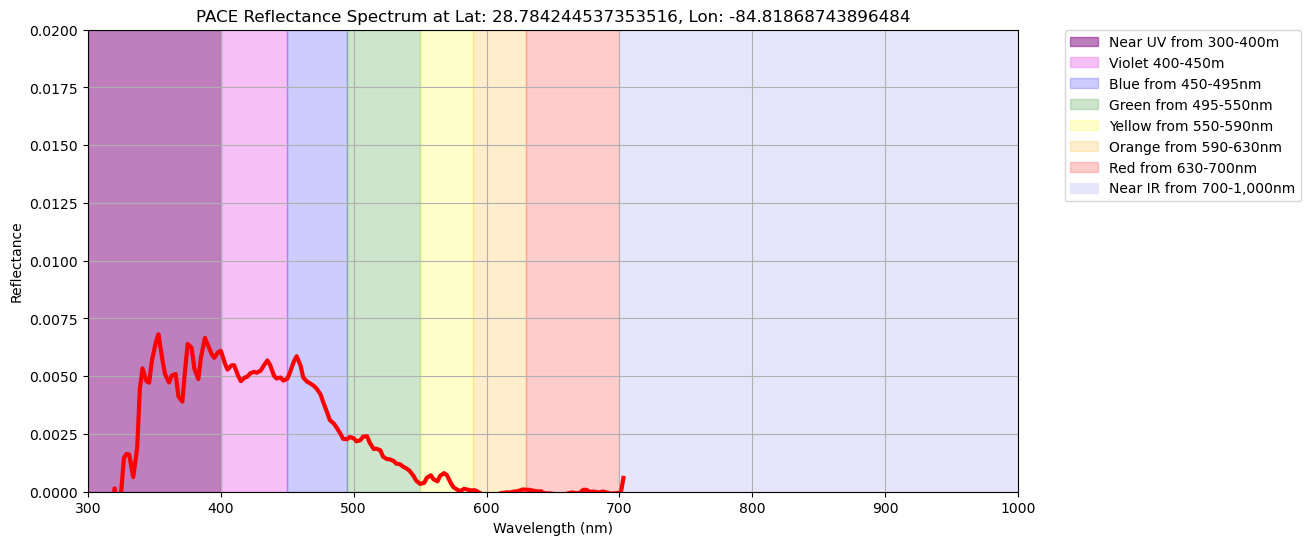

In [20]:
plot_wavelength(target_latitude = 25.5    , target_longitude = -91.25617)
plot_wavelength(target_latitude = 25.3280 , target_longitude = -83.9747)
plot_wavelength(target_latitude = 26.2776 , target_longitude = -84.0956)
plot_wavelength(target_latitude = 27.6581 , target_longitude = -83.2934)
plot_wavelength(target_latitude = 29.0023 , target_longitude = -83.4473)
plot_wavelength(target_latitude = 28.7811 , target_longitude = -84.8208)

---
---

# **Maps at different wavelengths:**
---

In [21]:
def Map_Reflectance(target_wavelength):
    wavelength_index = np.argmin(np.abs(wavelengths - target_wavelength))
    reflectance_at_target = reflectance_data[:, :, wavelength_index]

    # Plot the reflectance
    plt.figure(figsize=(12, 8))    
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    ax.set_extent([-98, -77, 20, 35], crs=ccrs.PlateCarree())  # Florida region
  
    # Old way
    #plt.contourf(longitudes, latitudes, reflectance_at_target,  vmin=0, vmax=0.03, transform=ccrs.PlateCarree(), cmap='rainbow')
    #plt.contourf(longitudes, latitudes, reflectance_at_target,  vmin=0, vmax=0.03, cmap='rainbow')

    
    # Plot the reflectance data using pcolormesh
    #im = ax.pcolormesh(lon, lat, reflectance_at_target,  vmin=0, vmax=0.1, cmap='rainbow')
    im = ax.pcolormesh(lon, lat, reflectance_at_target, cmap='rainbow')
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
    
    # Set ticks and format them
    ax.set_xticks(np.linspace(-91, -77, 5), crs=map_projection)
    ax.set_yticks(np.linspace(20, 35, 5), crs=map_projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.colorbar(im, label=f'Reflectance at {target_wavelength} nm')
    plt.title(f'Reflectance at {target_wavelength} nm around Florida')
    plt.show()


## **Basic Mapping of Reflectance Data Example:**


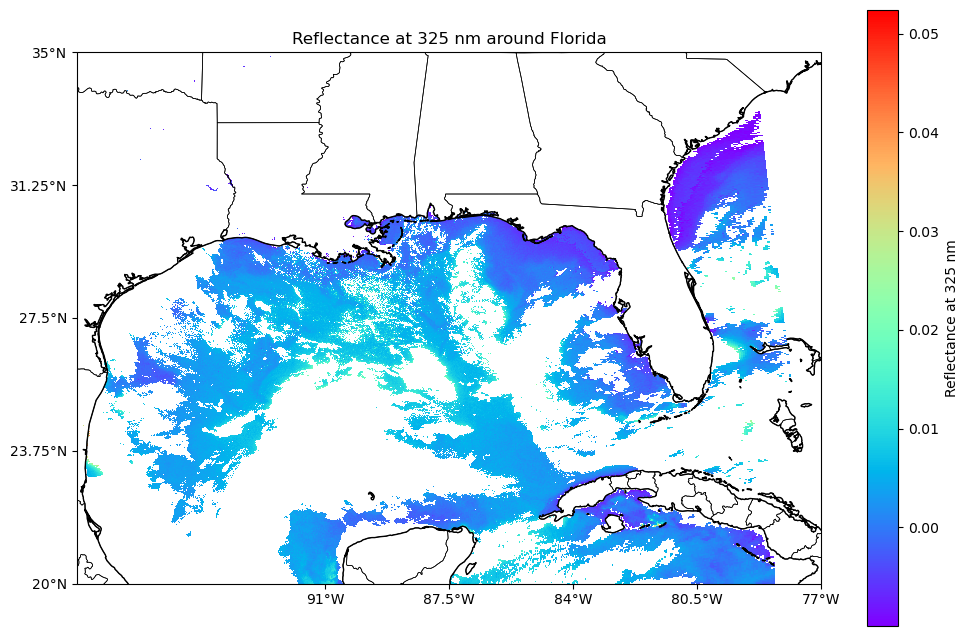

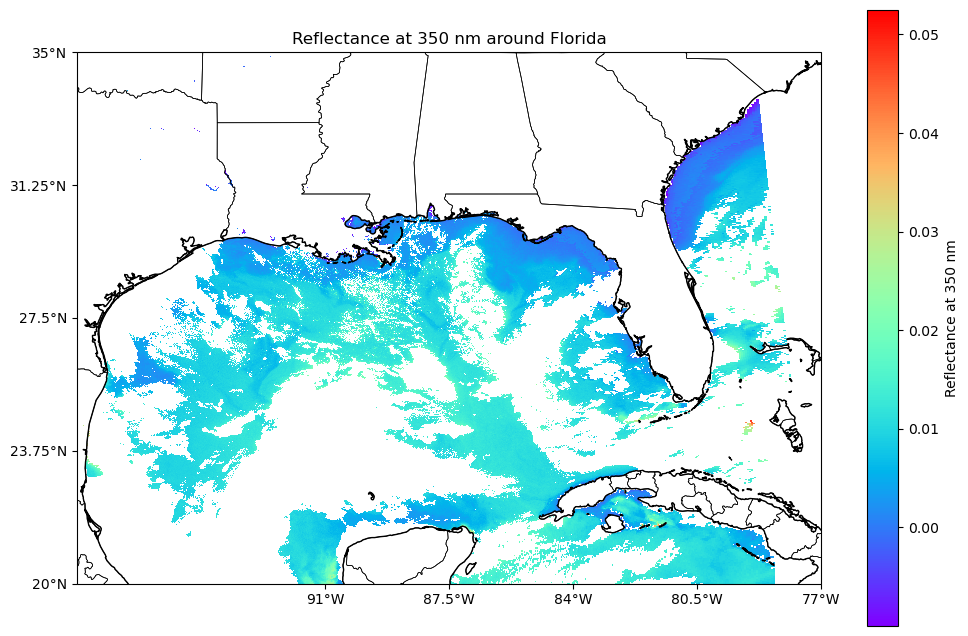

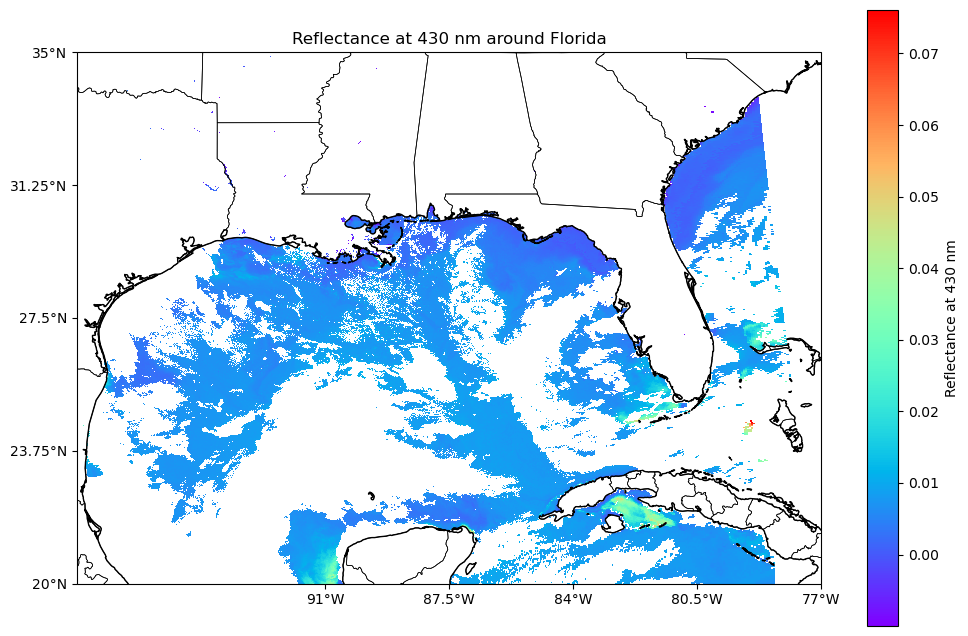

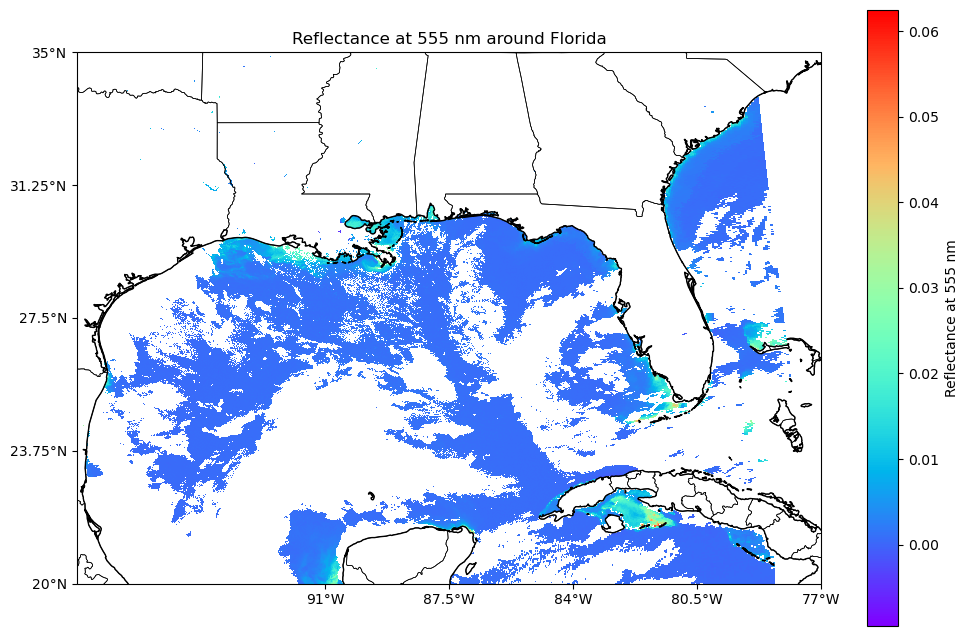

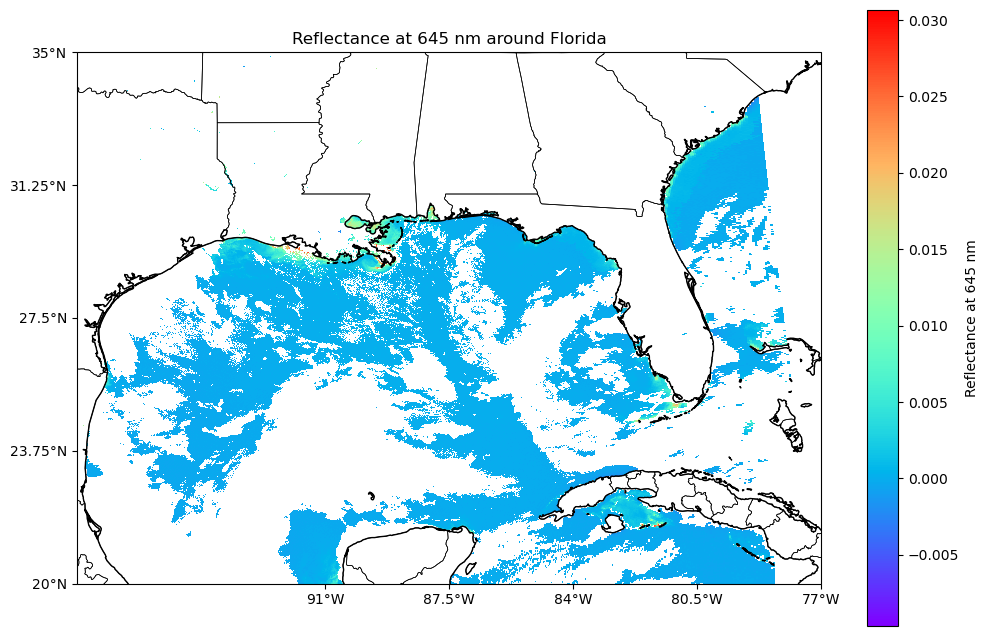

In [22]:
Map_Reflectance(target_wavelength=325)
Map_Reflectance(target_wavelength=350)
Map_Reflectance(target_wavelength=430)
Map_Reflectance(target_wavelength=555)
Map_Reflectance(target_wavelength=645)

---
---
# **Chlorophyl Calculations using Earth Data Tools Method Data (2023) used with PACE Data**
---

    Viewing Chlorophyll a — Algorithm Publication Tool.pdf

    Jeremy Werdell and John O'Reilly and Chuanmin Hu and Lian Feng and Zhongping Lee and Bryan Franz and Sean Bailey and Christopher Proctor, Chlorophyll a, Earth Data Publications Tool, November 6, 2023

The algorithm proceeds as follows:
1. chlor_a is first calculated using the CI algorithm, which is a three-band reflectance difference algorithm employing the difference between sensor specific Rrs in the green band and a reference formed linearly between Rrs in the blue and red bands (bands are instrument specific - see Table 1):

    CI = Rrs(λgreen) − [Rrs(λblue) + (λgreen − λblue)/(λred − λblue) ∗ (Rrs(λred) − Rrs(λblue))] 

Final calculation of CI chlor_a is done using two coefficients (a0CI = -0.4287 and a1CI = 230.47) specified by Hu et al (2019), where:

    chlor_a = 10(a0CI +a1CI ∗CI)

2. chlor_a is then calculated following the OCx algorithm, which is a fourth-order polynomial
relationship between a ratio of Rrs and chlor_a: 


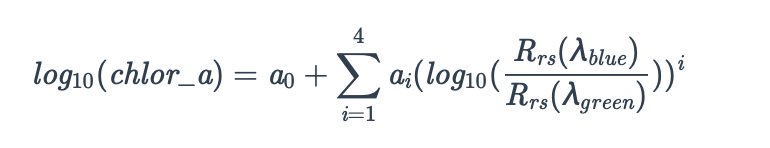

where the numerator, Rrs(λblue), is the greatest of several input Rrs values and the coefficients, a0-a4, are sensor-specific. The coefficients used for the OCx component of the algorithm in standard processing are listed in Table 1 below. In most cases these are taken directly from (O'Reilly & Werdell, 2019).


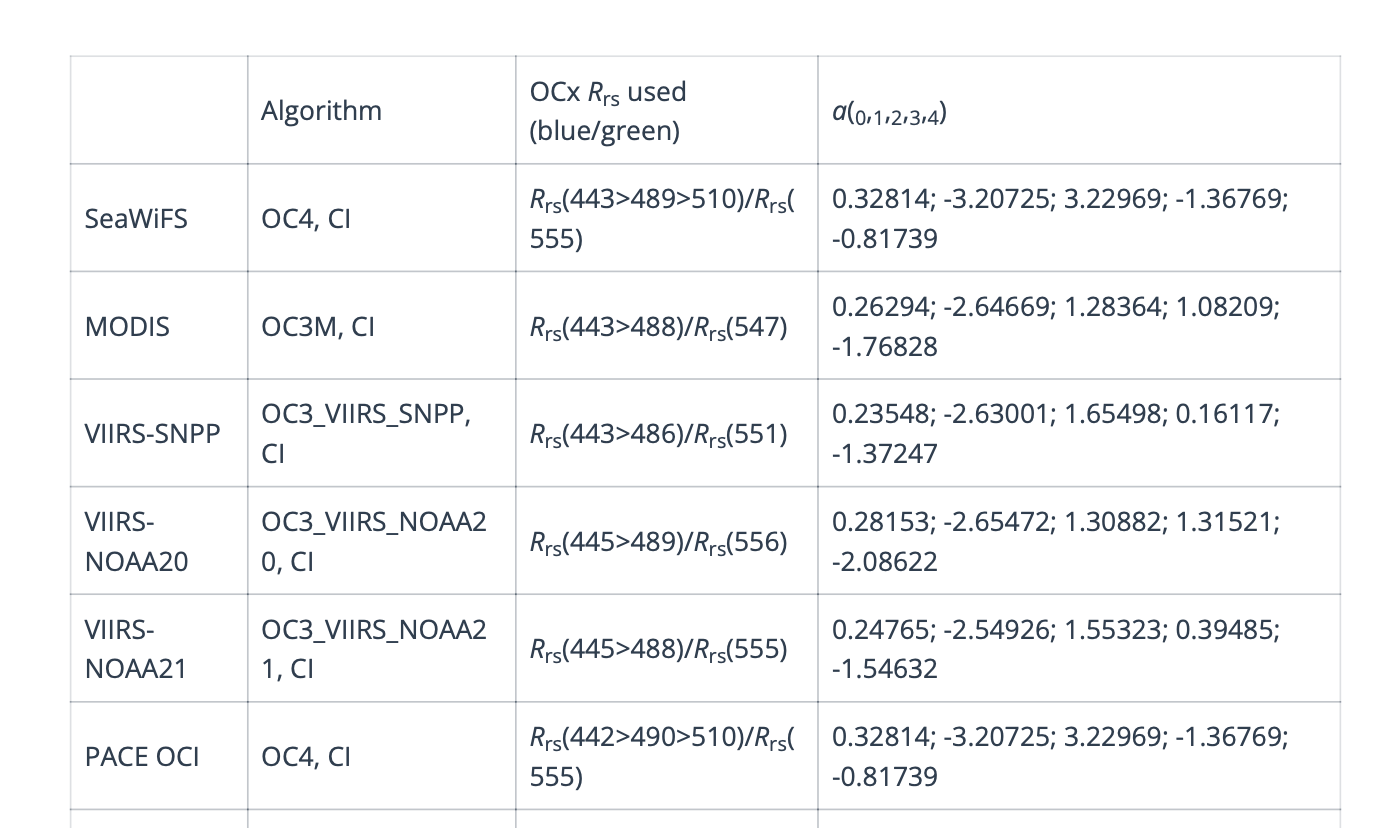

3. For chlor_a retrievals below 0.25 mg m-3, the CI algorithm is used.
For chlor_a retrievals above 0.35 mg m-3, the OCx algorithm is used. In between these values, the CI and OCx algorithm are blended using a weighted approach:
chlor_a = chlor_aCI (t2 − chlor_aCI ) + chlor_aOCx(chlor_aCI − t1) t2 − t1 t2 − t1
with t1 = 0.25, and t2=0.35 (edges of the current blending region).
For the CI algorithm, the nearest band to 443, 555, and 670 nm is used for the blue, green, and red band, respectively, for all sensors. For sensors that do not have a band very close to 555 nm, a correction is performed to shift the nearest green band Rrs to 555 nm. That correction is as follows:
For spectral bands (λ0) in the range of 543 –567 nm, Rrs(λ0) can be converted to Rrs(555) using the following equations, with sw as a threshold value:

If λ0 = 555±2 nm,

    Rrs(555) = Rrs(λ0)

If Rrs(λ0) < sw,

    Rrs(555) = 10(a1∗log10(Rrs(λ0))−b1)


If Rrs(λ0) ≥ sw,

    Rrs(555) = a2 ∗ Rrs(λ0) − b2

For different spectral bands (λ0), sw and a1, b1, a2, and b2 values are shown in Table 2.

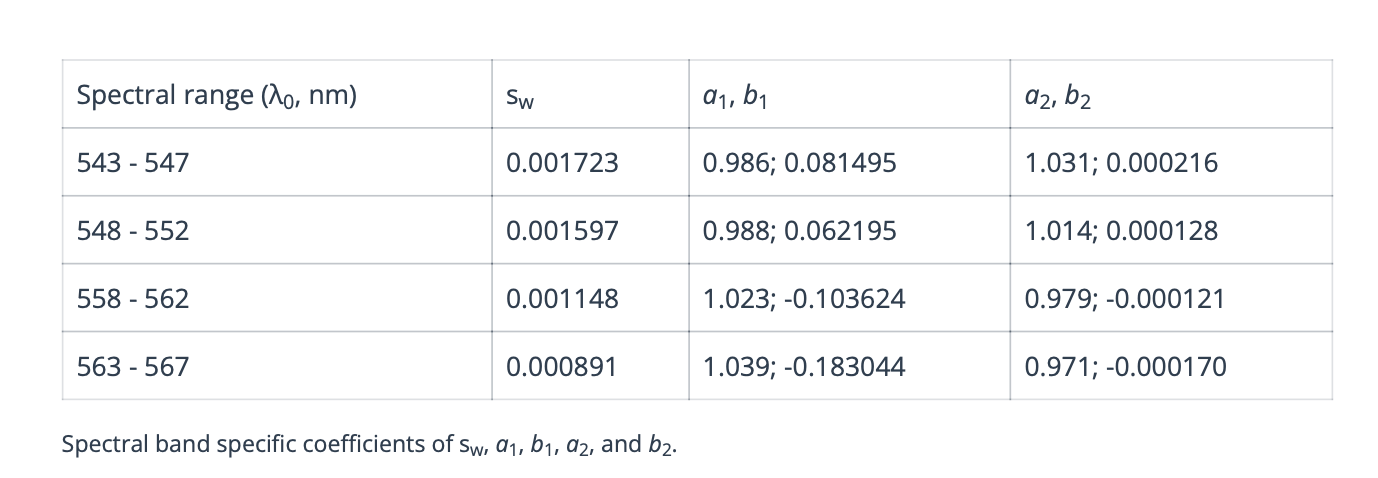

In [23]:
# Final Code that Works Great and has OCx from my interpretation of the following document

'''
Earth Data Tools Method Datad 2023 used for PACE Data

Viewing Chlorophyll a — Algorithm Publication Tool.pdf

Jeremy Werdell and John O'Reilly and Chuanmin Hu and Lian Feng and 
Zhongping Lee and Bryan Franz and Sean Bailey and Christopher Proctor, 
Chlorophyll a, Earth Data Publications Tool, November 6, 2023
'''

# Assume 'wavelengths' and 'reflectance_data' are defined
# wavelengths = ...
# reflectance_data = ...

# Identify indices for the required bands
band_442 = np.argmin(np.abs(wavelengths - 442))
band_490 = np.argmin(np.abs(wavelengths - 490))
band_510 = np.argmin(np.abs(wavelengths - 510))
band_555 = np.argmin(np.abs(wavelengths - 555))
band_670 = np.argmin(np.abs(wavelengths - 670))

print("Band 442 index:", band_442)
print("Band 490 index:", band_490)
print("Band 510 index:", band_510)
print("Band 555 index:", band_555)
print("Band 670 index:", band_670)

# Extract reflectance values at the required wavelengths
Rrs_442 = reflectance_data[:, :, band_442]
Rrs_490 = reflectance_data[:, :, band_490]
Rrs_510 = reflectance_data[:, :, band_510]
Rrs_555 = reflectance_data[:, :, band_555]
Rrs_670 = reflectance_data[:, :, band_670]

'''
1. chlor_a is first calculated using the CI algorithm, which is a three-band reflectance difference algorithm employing the difference between sensor specific Rrs in the green band and a reference formed linearly between Rrs in the blue and red bands (bands are instrument specific - see Table 1):
CI = Rrs(λgreen) − [Rrs(λblue) + (λgreen − λblue)/(λred − λblue) ∗ (Rrs(λred) − Rrs(λblue))] 
'''

# Calculate CI
CI = Rrs_555 - (Rrs_442 + (555 - 442) / (670 - 442) * (Rrs_670 - Rrs_442))

# A calculation of CI chlor_a is done using two coefficients (a0CI = -0.4287 and a1CI = 230.47) specified by Hu et al (2019), where:
# chlor_a = 10**(-0.4287 + 230.47 * CI)
# is this used for anything?


'''
2. chlor_a is then calculated following the OCx algorithm, which is a fourth-order polynomial relationship between a ratio of Rrs and chlor_a: 
'''
    
# Calculate chlor_a using CI
chlor_aCI = 10**(0.32814 + -3.20725*np.log10(Rrs_442 / Rrs_555)**1 + 
                            3.22969*np.log10(Rrs_442 / Rrs_555)**2 + 
                           -1.36769*np.log10(Rrs_442 / Rrs_555)**3 + 
                           -0.81739*np.log10(Rrs_442 / Rrs_555)**4)


'''
OCx Method (I think?)
'''

# Define OCx algorithm coefficients for OC4v6 as an example
a0, a1, a2, a3, a4 = -0.3704, -3.9622, 1.7441, 1.4487, -0.2874

# Calculate the OCx ratio
R = np.maximum.reduce([Rrs_442 / Rrs_555, Rrs_490 / Rrs_555, Rrs_510 / Rrs_555])


# Calculate chlor_a using OCx
log_chlor_a_OCx = a0 + a1 * np.log10(R) + a2 * np.log10(R)**2 + a3 * np.log10(R)**3 + a4 * np.log10(R)**4
chlor_a_OCx = 10**log_chlor_a_OCx



'''
3. For chlor_a retrievals below 0.25 mg m-3, the CI algorithm is used.

For chlor_a retrievals above 0.35 mg m-3, the OCx algorithm is used. 

In between these values, the CI and OCx algorithm are blended using a weighted approach:
'''


# Initialize the chlorophyll-a concentration array
chl_a_CI = np.zeros_like(CI)

# Define thresholds
t1 = 0.25
t2 = 0.35

# Apply the OCI algorithm to estimate chlorophyll concentration
positive_CI_mask = chlor_aCI > t2
negative_CI_mask = chlor_aCI < t1
blended_CI_mask = (~positive_CI_mask) & (~negative_CI_mask)

# Calculate chlorophyll-a for positive CI values
chl_a_CI[positive_CI_mask] = chlor_aCI[positive_CI_mask]

# Calculate chlorophyll-a for negative CI values
chl_a_CI[negative_CI_mask] = chlor_a_OCx[negative_CI_mask]

# Blend CI and OCx for values in between
chl_a_CI[blended_CI_mask] = ((chlor_aCI[blended_CI_mask] * (t2 - chlor_aCI[blended_CI_mask])) / (t2 - t1) +
                             (chlor_a_OCx[blended_CI_mask] * (chlor_aCI[blended_CI_mask] - t1)) / (t2 - t1))


Band 442 index: 53
Band 490 index: 72
Band 510 index: 80
Band 555 index: 98
Band 670 index: 156


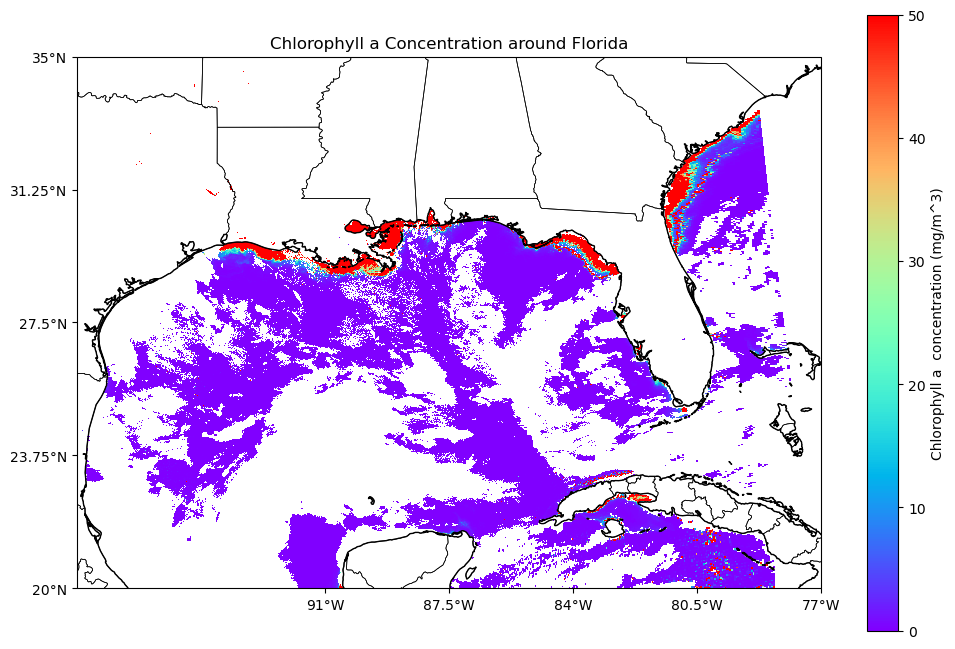

In [24]:
def plot_chlora(chl_a_CI):

    # Plot chlorophyll a concentration on a geospatial plot using Cartopy
    plt.figure(figsize=(12, 8))

    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-98, -77, 20, 35], crs=ccrs.PlateCarree())  # Florida region

    # Old way
    #plt.contourf(longitudes, latitudes, reflectance_at_target,  vmin=0, vmax=0.03, transform=ccrs.PlateCarree(), cmap='rainbow')
    #plt.contourf(longitudes, latitudes, reflectance_at_target,  vmin=0, vmax=0.03, cmap='rainbow')

    
    # Plot the reflectance data using pcolormesh
    #im = ax.pcolormesh(lon, lat, chl_a_OCI,  vmin=1.5, vmax=3., cmap='rainbow')
    im = ax.pcolormesh(lon, lat, chl_a_CI, vmin=0, vmax=50 ,cmap='rainbow')
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
    
 
    # Set ticks and format them
    ax.set_xticks(np.linspace(-91, -77, 5), crs=map_projection)
    ax.set_yticks(np.linspace(20, 35, 5), crs=map_projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Plot the data
    #plt.contourf(longitudes, latitudes, chl_a, transform=ccrs.PlateCarree(), cmap='viridis')
    #plt.contourf(lon, lat, chl_a, transform=ccrs.PlateCarree(), cmap='rainbow')
    plt.colorbar(im, label='Chlorophyll a  concentration (mg/m^3)')
    plt.title('Chlorophyll a Concentration around Florida')
    plt.show()


plot_chlora(chl_a_CI)